# Filtering expanded dataset

## Core Imports

In [1]:
# Generic Imports
import matplotlib.pyplot as plt
import pandas as pd

# File I/O
from pathlib import Path
import csv, json

# Typing and Subclassing
from typing import Iterable, Optional, Union
from dataclasses import dataclass, field

# Cheminformatics
from rdkit import Chem

# Custom imports
from polymerist.rdutils import rdkdraw
from polymerist.smileslib import substructures
from polymerist.monomers import specification

DIM    = 300
ASPECT = 3/2
rdkdraw.set_rdkdraw_size(DIM, ASPECT)
rdkdraw.disable_substruct_highlights()

# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')
# RXN_FILES_DIR = Path('rxn_smarts')

## Loading desired dataset

In [2]:
# input_data_path = FMT_DATA_DIR / 'nipu_urethanes_FMT.csv'
input_data_path = FMT_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
# input_data_path = FMT_DATA_DIR / '221010_trainingdata_DP-18_expanded_FMT.csv'
df = pd.read_csv(input_data_path)

## Defining queries for illegal chemistries

In [3]:
illegal_chem_queries = {
    'silicon' : Chem.MolFromSmarts('[Si]'),
    'sulfur'  : Chem.MolFromSmarts('[S]'),
    'metal'   : substructures.SPECIAL_QUERY_MOLS['metal'],
    # 'halogen' : substructures.SPECIAL_QUERY_MOLS['halogen'],
}

## Loading and backmapping premade reaction functional groups and templates

In [4]:
rxn_backmap = { # map NREL dataset mechanism names to pre-made rxn template names
    'amide'     : 'polyamide',
    'carbonate' : 'polycarbonate_phosgene',
    'ester'     : 'polyester',
    'imide'     : 'polyimide',
    'urethane'  : 'polyurethane_isocyanate',
    'NIPU'      : 'polyurethane_nonisocyanate',
    'vinyl'     : 'polyvinyl_head_tail'
}
assert(set(df['mechanism'].unique()).issubset(set(rxn_backmap.keys()))) # verify that we've mapped all reactions

with (RXN_FILES_DIR / 'rxn_backmap.json').open('w') as backmap_file:
    json.dump(rxn_backmap, backmap_file, indent=4)

In [5]:
from polymerist.rdutils.reactions import reactions

with (RXN_FILES_DIR / 'fn_group_smarts.json').open('r') as file:
    fn_group_smarts  = json.load(file)
    
fn_group_queries = { # RDKit Mols generated from SMARTS queries
    group_name : Chem.MolFromSmarts(smarts)
        for group_name, smarts in fn_group_smarts.items()
}

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

rxn_smarts_by_mech = {
    mechanism : rxns[rxnname].to_smarts()
        for mechanism, rxnname in rxn_backmap.items()
}

In [6]:
banned_monomers = [ # monomers which are, for one reason or another, disallowed
    'CC(C)(C)c1cc(c(Oc2ccc(cc2)N(c3ccc(N)cc3)c4ccc(N)cc4)c(c1)C(C)(C)C)C(C)(C)C'  # the extraordinary number of symmetries of this amine ("4-N-(4-aminophenyl)-4-N-[4-(2,4,6-tritert-butylphenoxy)phenyl]benzene-1,4-diamine")... 
]                                                                                 # ...mean it takes impractically long to isomorphism match during the Topology partition step

banned_monomer_queries = {}
for smiles in banned_monomers:
    exp_spi = specification.expanded_SMILES(smiles, assign_map_nums=False)
    banned_monomer_queries[smiles] = Chem.MolFromSmiles(exp_spi, sanitize=False)

## Utility functions

In [7]:
from enum import Enum, auto

@dataclass
class MonomerInfo:
    '''For encapsulating salient info about an individual monomer'''
    smiles        : str
    fn_group_name : str
    IUPAC_name    : str

@dataclass
class MonomersInfo:
    '''For encapsulating information about a collection of reacting monomers'''
    reactant_smiles  : str
    canonical_smiles : str
    polymer_name     : str = field(default_factory=str)
    iupac_names      : list[str] = field(default_factory=list)

class FilterRejectionReason(Enum):
    '''For capturing information about which filtering step a monomer didn't pass'''
    BAD_NUM_MONOMERS      = auto()
    ILLEGAL_ATOMS         = auto()
    NO_RXN_TEMPLATE_MATCH = auto()
    BAD_NUM_FN_GRPS       = auto()
    BANNED_MONOMER        = auto()

In [8]:
from polymerist.monomers import specification
from polymerist.rdutils.bonding import combined_rdmol
from polymerist.genutils.textual.encoding import hash_to_alphanumeric
from polymerist.smileslib.chemdbqueries import get_property_from_smiles


def process_monomer_input(monomer_smiles : str, rxn_smarts : str, allowed_functionalities : set[int]=None) -> Union[FilterRejectionReason, MonomersInfo]:
    '''For screening and expanding SMILES input to the MD polymer building workflow'''
    # set mutable defaults, initialize objects
    if allowed_functionalities is None:
        allowed_functionalities = {2}

    indiv_smiles = monomer_smiles.split('.') # opting for direct string-based approach here rather than RDKit Mol fragmenting for speed, and to avoid clunky str -> Mol -> str conversion
    rxn = reactions.AnnotatedReaction.from_smarts(rxn_smarts)

    # 1) Determine number of distrinct monomers in passed SMILES string
    if len(indiv_smiles) != rxn.GetNumReactantTemplates():
        return FilterRejectionReason.BAD_NUM_MONOMERS
    
    # Generate expanded SMILES string and corresponding RDKit Mol for all monomers
    monomers_by_exp_smiles : dict[str, Chem.Mol] = {}
    exp_smiles_by_monomers : dict[Chem.Mol, str] = {} # reverse lookup to figure out the correct smiles given a molecule
    indiv_monomers         : list[Chem.Mol] = []
    
    for smi in indiv_smiles: # wait to expand SMILES until after count filtering for speed
        exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
        monomer = Chem.MolFromSmiles(exp_smi, sanitize=False)

        # 2) Catch monomers with illegal atoms or, if none are present, generate expanded SMILES string and corresponding RDKit Mol for all monomers
        if any(substructures.matching_labels_from_substruct_dict(monomer, illegal_chem_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.ILLEGAL_ATOMS

        # 3) Exclude any monomers which are structurally disallowed
        if any(substructures.matching_labels_from_substruct_dict(monomer, banned_monomer_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.BANNED_MONOMER
        
        indiv_monomers.append(monomer)
        monomers_by_exp_smiles[exp_smi] = monomer
        exp_smiles_by_monomers[monomer] = exp_smi

    # 4) Determine if monomer functionalizations match the advertised rxn, and if so in what order they should appear
    ordered_monomers = rxn.valid_reactant_ordering(indiv_monomers)
    if ordered_monomers is None:
        return FilterRejectionReason.NO_RXN_TEMPLATE_MATCH

    # produce monomers based on a valid ordering if one is found
    reactant_smis : list[str] = []
    iupac_names     : list[str] = []

    for i, monomer in enumerate(ordered_monomers):
        # 5) Determine if all monomers are only have the desired functionalization numbers 
        react_templ = rxn.GetReactantTemplate(i)
        if substructures.num_substruct_queries_distinct(monomer, react_templ) not in allowed_functionalities:
            return FilterRejectionReason.BAD_NUM_FN_GRPS
        
        smiles = exp_smiles_by_monomers[monomer]
        reactant_smis.append(smiles)

        # Query IUPAC names for each monomer - NOTE: not done in the monomer expansion loop as the name query is the slowest step and should preferably alled as few times as possible
        iupac_name = get_property_from_smiles(smiles, prop_name='iupac_name') # returns NoneType if no query is found
        iupac_names.append(iupac_name)

    # if a monomer has gotten here, that means it's passed!
    canon_smi = Chem.CanonSmiles(monomer_smiles)
    return MonomersInfo(
        reactant_smiles='.'.join(reactant_smis),
        canonical_smiles=canon_smi,
        polymer_name=hash_to_alphanumeric(canon_smi),  # Produce unique identifier hash from canonical (incomplete) SMILES of monomers as fragments of single mol
        iupac_names=iupac_names
    )

# Filter dataset

## Generate filtered Series (either error codes or MonomerInfo) from initial dataset

In [9]:
from rich.progress import track

targ_df = df
# targ_df = df.head(20)
# targ_df = df[df.mechanism == 'vinyl']

proc_output = []
for (i, row) in track(targ_df.iterrows(), total=len(targ_df), description='Processing SMILES dataset...'):
    proc = process_monomer_input(row.smiles_monomer, rxn_smarts_by_mech[row.mechanism])
    proc_output.append(proc)

proc_output = pd.Series(proc_output) # convert from list to Series, partition by failure state - NOTE: done in pandas to givee access to indices of passed monomers in original frame
rejected = proc_output.map(lambda out : isinstance(out, FilterRejectionReason))
is_valid = ~rejected

Output()

## Expand successful monomers into labelled DataFrame

In [10]:
# extract original data, processed smiles monomers, and reaction info from indices of valid chemistries 
passes_index = proc_output.index[is_valid]
passes_orig_data = df.iloc[passes_index].rename(columns={'mechanism' : 'mechanism_original'}, inplace=False) # rename prior mechanism column to free up the label for the assigned reaction name

passes_reactant_info = pd.DataFrame.from_records(proc_output[is_valid].map(lambda x : x.__dict__), index=passes_index)
passes_rxn_names  = passes_orig_data['mechanism_original'].map(rxn_backmap).rename('mechanism')           # make the newly-assigned reaction name the "true" mechanism
passes_rxn_smarts = passes_rxn_names.map(lambda rxnname : rxns[rxnname].to_smarts()).rename('rxn_smarts') # changes name to be distinct (name is kept by default after map())

# concatenate all passing data along columns, indexed by mechanism and hashname
passes = pd.concat([passes_reactant_info, passes_rxn_names, passes_rxn_smarts, passes_orig_data], axis=1)
passes.set_index(['mechanism', 'polymer_name'], inplace=True)
passes

reactant_smiles  \
mechanism              polymer_name                                                                
polycarbonate_phosgene FaOHFNO7oYNqYGhXnD703A  [H]-[O]-[C]1=[C](-[H])-[C](-[H])=[C](-[C](-[C]...   
polyamide              QdVpd1AWRBc9PrYHQZThTQ  [H]-[O]-[C]1=[C](-[C](-[F])(-[F])-[F])-[C](-[H...   
polycarbonate_phosgene cp1Xaspka3gAI0wjE-bTGQ  [H]-[O]-[C]1=[C](-[C](-[H])(-[H])-[H])-[C](-[H...   
polyimide              Y6mf-wCn312PqwcpGxyfKQ  [H]-[C]1=[C](-[H])-[C](-[H])=[C]2-[C](=[C]-1-[...   
                       OXbKQRsPCyXtrGyjNzw-cw  [H]-[C]1=[C](-[H])-[C](-[N](-[H])-[H])=[C](-[H...   
...                                                                                          ...   
                       F07jsH2ay_U-FBIutSlUSQ  [H]-[C]1=[C](-[N](-[H])-[H])-[C](-[C](-[H])(-[...   
                       EwbVEvZajDr_xpk4-ylkNg  [H]-[C]1=[C](-[C](-[H])(-[H])-[H])-[C](-[N](-[...   
polycarbonate_phosgene uDQRx-76psa5Y6i0gZthhw  [H]-[O]-[C]1=[C](-[H])-[C](-[H])=[C](-[C]2(-[C...   
polyester              _DjbMwDzRDMNOmGttXk8wQ  [H]-[O]-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[...   
polyimide              zExvWddg6yp4CtgmmOMQEQ  [H]-[C]1=[C](-[H])-[C](-[O]-[C]2=[C](-[H])-[C]...   

                                                                                canonical_smiles  \
mechanism              polymer_name                                                                
polycarbonate_phosgene FaOHFNO7oYNqYGhXnD703A  O=C(Cl)Cl.Oc1ccc(C(c2ccc(O)cc2)(C(F)(F)F)C(F)(...   
polyamide              QdVpd1AWRBc9PrYHQZThTQ  Nc1ccc(-c2ccc(Oc3ccc(Oc4cc(-c5ccc(N)cc5)cc(C(F...   
polycarbonate_phosgene cp1Xaspka3gAI0wjE-bTGQ  Cc1cc(C(C)(C)c2cc(C)c(O)c(C)c2)cc(C)c1O.O=C(Cl)Cl   
polyimide              Y6mf-wCn312PqwcpGxyfKQ  Nc1ccc(C2(c3ccc(N)cc3)c3ccccc3-c3ccccc32)cc1.O...   
                       OXbKQRsPCyXtrGyjNzw-cw  CC(C)(C)c1cc(C(=O)c2ccc3c(c2)C(=O)OC3=O)cc(C(=...   
...                                                                                          ...   
                       F07jsH2ay_U-FBIutSlUSQ  Cc1cc(C(c2ccc(N)c(C)c2)(C(F)(F)F)C(F)(F)F)ccc1...   
                       EwbVEvZajDr_xpk4-ylkNg  Cc1cc(C)c(N)c(C)c1N.O=C(c1ccc2c(c1)C(=O)OC2=O)...   
polycarbonate_phosgene uDQRx-76psa5Y6i0gZthhw        O=C(Cl)Cl.Oc1ccc(C2(c3ccc(O)cc3)CCCCCC2)cc1   
polyester              _DjbMwDzRDMNOmGttXk8wQ                            O=C(O)CCCCC(=O)O.OCCCCO   
polyimide              zExvWddg6yp4CtgmmOMQEQ  Nc1ccc(Oc2ccc(C(c3ccc(Oc4cccc(Oc5ccc(C(c6ccc(O...   

                                                                                     iupac_names  \
mechanism              polymer_name                                                                
polycarbonate_phosgene FaOHFNO7oYNqYGhXnD703A  [4-[1,1,1,3,3,3-hexafluoro-2-(4-hydroxyphenyl)...   
polyamide              QdVpd1AWRBc9PrYHQZThTQ              [None, Benzene-1,3-dicarboxylic acid]   
polycarbonate_phosgene cp1Xaspka3gAI0wjE-bTGQ  [4-[2-(4-hydroxy-3,5-dimethylphenyl)propan-2-y...   
polyimide              Y6mf-wCn312PqwcpGxyfKQ  [4-[9-(4-aminophenyl)fluoren-9-yl]aniline, 5-[...   
                       OXbKQRsPCyXtrGyjNzw-cw  [benzene-1,3-diamine, 5-[3-tert-butyl-5-(1,3-d...   
...                                                                                          ...   
                       F07jsH2ay_U-FBIutSlUSQ  [4-[2-(4-amino-3-methylphenyl)-1,1,1,3,3,3-hex...   
                       EwbVEvZajDr_xpk4-ylkNg  [2,4,6-Trimethylbenzene-1,3-diamine, 5-(1,3-di...   
polycarbonate_phosgene uDQRx-76psa5Y6i0gZthhw  [4-[1-(4-hydroxyphenyl)cycloheptyl]phenol, Car...   
polyester              _DjbMwDzRDMNOmGttXk8wQ                [Butane-1,4-diol, hexanedioic acid]   
polyimide              zExvWddg6yp4CtgmmOMQEQ  [None, 5-(1,3-dioxo-2-benzofuran-5-yl)-2-benzo...   

                                                                                      rxn_smarts  \
mechanism              polymer_name                                           

## Show distribution of failure cases

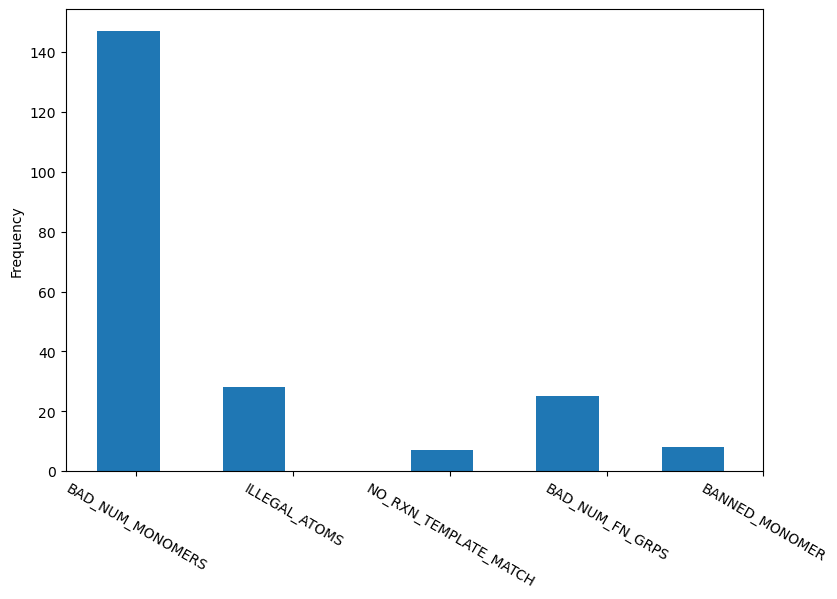

In [11]:
dim = 6
aspect= 3/2

plt.figure(figsize=(dim*aspect, dim))

rejects_reasons = proc_output[rejected]
rejects     = rejects_reasons.map(lambda r : r.name)
rejects_ids = rejects_reasons.map(lambda x : x.value)

ax = rejects_ids.plot(kind='hist')
ax.set_xticks([(i.value + 0.25) for i in FilterRejectionReason])
ax.set_xticklabels([i.name for i in FilterRejectionReason], rotation=-30)

plt.show()

## Save filtered DataFrame for next steps to avoid reprocessing

In [12]:
from polymerist.genutils.fileutils.pathutils import assemble_path, dotless

PROC_DATA_DIR.mkdir(exist_ok=True)
clean_input_stem = input_data_path.stem.removesuffix('_FMT')
extension = dotless(input_data_path)

# save filtered dataset to filtered directory to store caclulations
passes_path  = assemble_path(PROC_DATA_DIR, input_data_path.stem.replace(' ', '_'), postfix='FILTERED_NEWSTYLE', extension=extension)
passes.to_csv(passes_path)

rejects_path = assemble_path(PROC_DATA_DIR, input_data_path.stem.replace(' ', '_'), postfix='REJECTED_NEWSTYLE', extension=extension)
rejects.to_csv(rejects_path)